In [6]:
import tensorflow as tf
from tensorflow import keras
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
# Define the directory containing the preprocessed images
data_dir = 'CutmixSplitMonkeypoxSkinImageDataset'



In [17]:
# Define the size of the images
img_size = (128, 128)

# Define the batch size
batch_size = 128
# Define the data generators for the training, validation, and test sets

from keras.preprocessing.image import ImageDataGenerator

# Define the data generators for the training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse')  # Changed from 'categorical' to 'sparse'

val_generator = val_datagen.flow_from_directory(
        os.path.join(data_dir, 'val'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse')  # Changed from 'categorical' to 'sparse'

test_generator = test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse')  # Changed from 'categorical' to 'sparse'



Found 614 images belonging to 4 classes.
Found 75 images belonging to 4 classes.
Found 81 images belonging to 4 classes.


In [18]:
# Define the architecture of the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def get_vit_model(input_shape, num_classes):
    # Patch size
    patch_size = 4
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    # Embedding layer for the patch embeddings
    embeddings_dim = 256
    inputs = layers.Input(shape=input_shape)
    patches = layers.experimental.preprocessing.Rescaling(scale=1.0 / 255)(inputs)
    patches = layers.experimental.preprocessing.Resizing(input_shape[0] // patch_size, input_shape[1] // patch_size)(patches)
    patches = layers.Reshape((-1, patch_size * patch_size * input_shape[2]))(patches)
    patches = layers.Dense(embeddings_dim)(patches)  # Change here: use Dense layer to obtain embeddings
    embeddings = layers.Dropout(0.1)(patches)
    
    # Transformer layers
    num_transformer_blocks = 6
    for _ in range(num_transformer_blocks):
        # Multi-head self-attention
        x1 = layers.MultiHeadAttention(num_heads=8, key_dim=embeddings_dim // 8)(embeddings, embeddings)
        x1 = layers.Dropout(0.1)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1 + embeddings)
        # MLP
        x2 = layers.Dense(units=4 * embeddings_dim, activation='relu')(x1)
        x2 = layers.Dense(units=embeddings_dim)(x2)
        x2 = layers.Dropout(0.1)(x2)
        embeddings = layers.LayerNormalization(epsilon=1e-6)(x2 + x1)
    
    # Classification head
    x = layers.GlobalAveragePooling1D()(embeddings)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    # Define the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = get_vit_model(input_shape=(128, 128, 3), num_classes=4)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 128, 128, 3)  0           ['input_7[0][0]']                
                                                                                                  
 resizing_4 (Resizing)          (None, 32, 32, 3)    0           ['rescaling_4[0][0]']            
                                                                                                  
 reshape_3 (Reshape)            (None, 64, 48)       0           ['resizing_4[0][0]']       

In [19]:
# Compile the model
# Compile the model
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [20]:
# Train the model on the training set
# Fit the model
history = model.fit(train_generator,epochs=15,validation_data=val_generator)

Epoch 1/15
5/5 [==============================] - 23s 3s/step - loss: nan - accuracy: 0.1824 - val_loss: nan - val_accuracy: 0.1333
Epoch 2/15
5/5 [==============================] - 13s 3s/step - loss: nan - accuracy: 0.1384 - val_loss: nan - val_accuracy: 0.1333
Epoch 3/15
5/5 [==============================] - 13s 3s/step - loss: nan - accuracy: 0.1384 - val_loss: nan - val_accuracy: 0.1333
Epoch 4/15
5/5 [==============================] - 13s 3s/step - loss: nan - accuracy: 0.1384 - val_loss: nan - val_accuracy: 0.1333
Epoch 5/15
5/5 [==============================] - 13s 3s/step - loss: nan - accuracy: 0.1384 - val_loss: nan - val_accuracy: 0.1333
Epoch 6/15
5/5 [==============================] - 13s 3s/step - loss: nan - accuracy: 0.1384 - val_loss: nan - val_accuracy: 0.1333
Epoch 7/15
5/5 [==============================] - 13s 3s/step - loss: nan - accuracy: 0.1384 - val_loss: nan - val_accuracy: 0.1333
Epoch 8/15
5/5 [==============================] - 13s 3s/step - loss: nan - 

In [21]:
import matplotlib.pyplot as plt

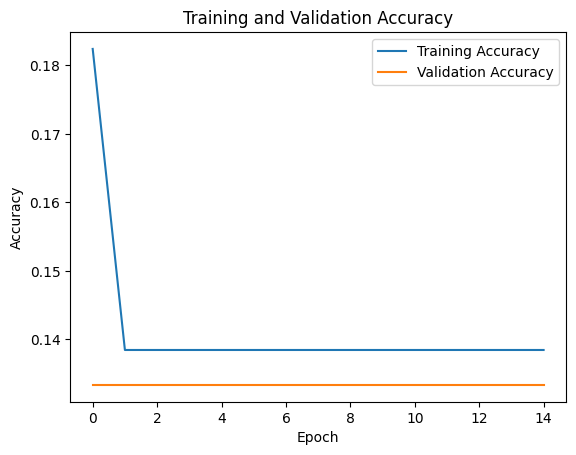

In [22]:
# Plot the training and validation accuracy and loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

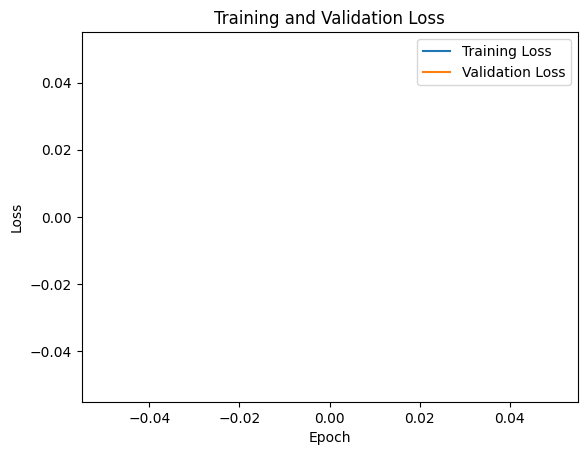

In [23]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [24]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

1/1 [==============================] - 1s 665ms/step - loss: nan - accuracy: 0.1481
Test accuracy: 0.14814814925193787


In [25]:
# Save the trained model to a file
model.save('vit.h5')